# 1. Import required libraries

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import randint as sp_randint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams
from sklearn.externals import joblib
np.set_printoptions(precision=3)
%matplotlib inline

# 2. Load cleaned data

In [2]:
#load cleaned data
data = pd.read_csv('data/clean_titanic.csv')

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [4]:
feature = ['pclass',  'sex', 'age','fare']
X = data[feature]
y = data.survived
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=1234)

# 3. Hyper-parameter Selection

We will be using Grid search to find best hyper-parameters of the model.

## 3.1 Simple Grid Search
Let us start with simple grid search on KNN classifier

In [24]:
neighbour = [1,2,3,4,5]
best_score = 0
for k in neighbour:
    knn     =  KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_p = knn.predict(X_validation)
    f_score = f1_score(y_validation, y_p)
    if f_score > best_score:
        best_score = f_score
        best_parameter = {"neighbour":k}
print("best F-1 score: %.2f" % best_score)
print("best parameter: {}".format(best_parameter))
        

best F-1 score: 0.88
best parameter: {'neighbour': 1}


From the above results the best value of neighbour is 1. However this result can not be generalized to new data.

To address this problem it is better to split the data again into three partition namely:
- Training set which will be used for building model.
- Validation set which will be used for selecting hyper-parameters.
- Test set which will be used for model evaluation.

as follows:

In [25]:
# First we split training set further into training and validation sets
X_new_train, X_validation, y_new_train, y_validation = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
print("Size new training set: %d" %X_new_train.shape[0])
print("Size validation set: %d" %X_validation.shape[0])
print("Size test set: %d" %X_test.shape[0])

Size new training set: 942
Size validation set: 105
Size test set: 262


In [26]:
neighbour = [1,2,3,4,5]
best_score = 0
for k in neighbour:
    knn     =  KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_new_train,y_new_train)
    y_p = knn.predict(X_validation)
    f_score = f1_score(y_validation, y_p)
    if f_score > best_score:
        best_score = f_score
        best_parameter = {"neighbour":k}
        
knn_best = KNeighborsClassifier(n_neighbors=best_parameter['neighbour'])
knn_best.fit(X_train, y_train)
y_p_test = knn_best.predict(X_test)
f_score_test = f1_score(y_test, y_p_test)
print("best parameter: {}".format(best_parameter))
print("best F-1 score on validation: %.2f" % best_score)
print("best F-1 score on test: %.2f" % f_score_test)

best parameter: {'neighbour': 5}
best F-1 score on validation: 0.44
best F-1 score on test: 0.54


The limitation of the above approch is on how to split the data into training, validation and test set.

## 3.2 Grid search with Cross-validation

In [27]:
neighbour = [1,2,3,4,5]
best_score = 0
score='f1'

# Find best parameter
for k in neighbour:
    knn = KNeighborsClassifier(n_neighbors=k)
    skfold = model_selection.StratifiedKFold(n_splits=5)
    cv_results = model_selection.cross_val_score(knn, X_train, y_train, cv=skfold, scoring=score)
    if cv_results.mean() > best_score:
        best_score = cv_results.mean()
        best_parameter = {"neighbour":k}
        
# evaluate best parameter on test data
knn_best = KNeighborsClassifier(n_neighbors=best_parameter['neighbour'])
knn_best.fit(X_train, y_train)
y_p_test = knn_best.predict(X_test)
f_score_test = f1_score(y_test, y_p_test)
print("best parameter: {}".format(best_parameter))
print("best F-1 score on training: %.2f" % best_score)
print("best F-1 score on test: %.2f" % f_score_test)

best parameter: {'neighbour': 5}
best F-1 score on training: 0.57
best F-1 score on test: 0.54


## 3. 2.1 GridSearchCV
Despite the fact that the above procedure work, [sklearn](scikit-learn.org) has implemented a grid search class (GridSearchCV) which simply the whole procedure. To use this class:

In [10]:
from sklearn.model_selection import GridSearchCV

In [28]:
neighbour = [1,2,3,4,5]
best_score = 0
score='f1'
parameter = {'n_neighbors':neighbour}
skfold = model_selection.StratifiedKFold(n_splits=5)
knn = KNeighborsClassifier()
gridCV = GridSearchCV(knn, param_grid=parameter, scoring=score, cv=skfold)
gridCV.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [31]:
print("Test score: %.2f" %gridCV.score(X_test,y_test))
print("Training score: %.2f" %gridCV.best_score_)
print("Best parameter: %d" %gridCV.best_params_['n_neighbors'])

Test score: 0.54
Training score: 0.57
Best parameter: 5


Grid search is only suitable when you have few hyperparameter search space. Let us explore other type of grid search with Random grid search.

## 3.2.2 RandomizedSearchCV
RandomizedSearchCV is the best when the hyperparameter search space is large. Unlike GridSearchCV, RandomizedSearchCV evaluate a given number of random combination by selection random value for each hyperparameter.

In [32]:
from sklearn.model_selection import RandomizedSearchCV
neighbour = [1,2,3,4,5]
best_score = 0
score='f1'
parameter = {'n_neighbors':neighbour}
skfold = model_selection.StratifiedKFold(n_splits=5)
knn = KNeighborsClassifier()
gridRandom = RandomizedSearchCV(knn, parameter, scoring=score, cv=skfold, n_iter=5)
gridRandom.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'n_neighbors': [1, 2, 3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=0)

In [34]:
print("Test score: %.2f" %gridRandom.score(X_validation,y_validation))
print("Training score: %.2f" %gridRandom.best_score_)
print("Best parameter: %d" %gridRandom.best_params_['n_neighbors'])

Test score: 0.57
Training score: 0.57
Best parameter: 5


We will use RandomizedSearchCV to select best hyperparameters of the selected models (KNN and Random Forest)

# 4. Model Hyperparameters tuning

Random Forest hyperparameters 
- n_estimator : Number of decision trees
- max_feautures: Number of feautures to consider
- criterion : Function used to measure the quality
- min_weight_fraction_leaf : Minimum number of samples

KNN
- weight : Function to weight the neighbour
- n_neighbour: Number of neighbour to use



In [35]:
# specify parameters and distributions to sample from
param_rf = {"max_depth": [3, None],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

param_knn = {
              "weights": ['uniform', 'distance'],
              "n_neighbors":  sp_randint(1, 10)
           }


In [36]:
def random_parameter_search(X_train,y_train, X_test, y_test, score='f1'):
    knn     =  KNeighborsClassifier()
    rForest =  RandomForestClassifier()
    
    m_names = ["Nearest Neighbors",
                   "Random Forest",
                   ]
               
    
    models = [knn, rForest]
   
    
    parameter = [param_knn, param_rf]
    
    test_score  = []
    train_score = []
    best_parameter =[]
    
    for (i,model) in enumerate(models):
        print("Run %d model: %s" %(i,m_names[i]))
        skfold = model_selection.StratifiedKFold(n_splits=5)
        gridRandom = RandomizedSearchCV(model, parameter[i], scoring=score, cv=skfold, n_iter=10)
        gridRandom.fit(X_train,y_train)
        test_score.append(gridRandom.score(X_test,y_test))
        train_score.append(gridRandom.best_score_)
        best_parameter.append(gridRandom.best_params_)
        
    return m_names, test_score, train_score, best_parameter   

In [37]:
m_names, test_score, train_score, best_parameter = random_parameter_search(X_train,y_train, X_validation, y_validation, score='f1')

Run 0 model: Nearest Neighbors
Run 1 model: Random Forest


In [41]:
def plotbar(plot_name, names, result,title,ylabel):
    postion = np.arange(len(names))
    plt.bar(postion, result, align='center', color ='g')
    plt.xticks(postion, names, rotation=0)
    plt.ylabel(ylabel)
    plt.title(title)

In [42]:
names = ['KNN','RForest']

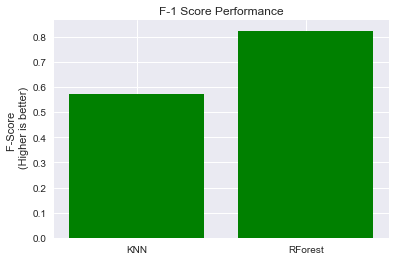

In [43]:
plotbar("Hyper_perfomance", names, test_score, "F-1 Score Performance", "F-Score \n (Higher is better)")

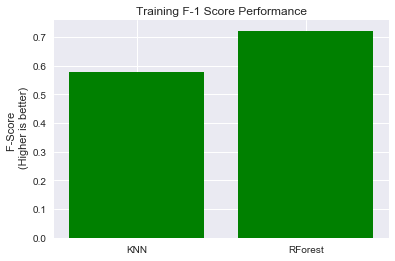

In [44]:
plotbar("Hyper_perfomance_training", names, train_score, "Training F-1 Score Performance", "F-Score \n (Higher is better)")

In [45]:
for (i, name) in enumerate(m_names):
    print("Model: {} :best_parameter: {}".format(name, best_parameter[i]))

Model: Nearest Neighbors :best_parameter: {'n_neighbors': 9, 'weights': 'uniform'}
Model: Random Forest :best_parameter: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 8}


In [46]:
for (i, name) in enumerate(m_names):
    print("{} :Test_score: {}".format(name, test_score[i]))

Nearest Neighbors :Test_score: 0.5714285714285715
Random Forest :Test_score: 0.823529411764706


From the above results, we found that Random forest show best performance for selected hyperparameters {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 8}

So finally we have our best improved model.

## Compare the tuned model and the previous one and save trained model on disk

In [54]:
def classifiers(X_train, y_train, X_validation, y_validation, score='f1'):
    rforest =  RandomForestClassifier()
    rforest_tuned =  RandomForestClassifier(criterion='entropy', max_depth=None,
                                            min_samples_leaf=2, min_samples_split=8,bootstrap=False)
    model_names = ["RForest_old","RForest_tuned"]
    
    models = [rforest, rforest_tuned]
    
    name= []
    results=[]
    avg_results = []
    f_score_test= []
   
    for (i,model) in enumerate(models):
      
        skfold = model_selection.StratifiedKFold(n_splits=5)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=skfold, scoring=score)
        results.append(cv_results)
        avg_results.append(cv_results.mean())
        msg = "%s: %f" % (model_names[i], cv_results.mean())
        print(msg)
        
        # save the model to disk
        filename = 'model/%s.sav' %(model_names[i])
        joblib.dump(model, filename)
        
        print("Run validation perfomance")
        model.fit(X_train, y_train)
        y_p = model.predict(X_validation)
        f_score = f1_score(y_validation, y_p)
        f_score_test.append(f_score)
    
        
        
    
    return avg_results, model_names, f_score_test 

##### Run the above code

In [55]:
result, names, test_score  = classifiers(X_train,y_train, X_validation, y_validation, score='f1')

RForest_old: 0.702016
Run validation perfomance
RForest_tuned: 0.716275
Run validation perfomance


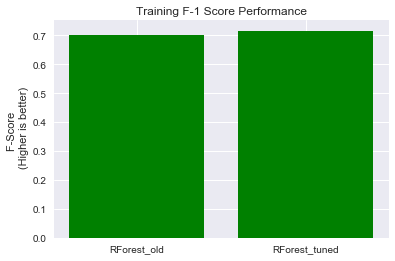

In [57]:
plotbar("_perfomance_training", names, result, "Training F-1 Score Performance", "F-Score \n (Higher is better)")


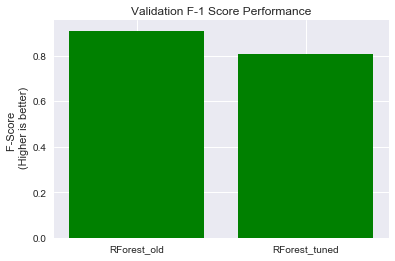

In [58]:
plotbar("_perfomance_validation", names, test_score, "Validation F-1 Score Performance", "F-Score \n (Higher is better)")

In [60]:
def test_classifiers(X_test,y_test):
    rforest = joblib.load('model/RForest_old.sav')
    rforest_tuned = joblib.load('model/RForest_tuned.sav')
    model_names = ["RForest_old","RForest_tuned"]
    
    models = [rforest, rforest_tuned]
    
   
    f_score_test= []
   
    for (i,model) in enumerate(models):
      
        y_p= model.predict(X_test)
        f_score_test.append(f1_score(y_test, y_p))
    
    return model_names, f_score_test 

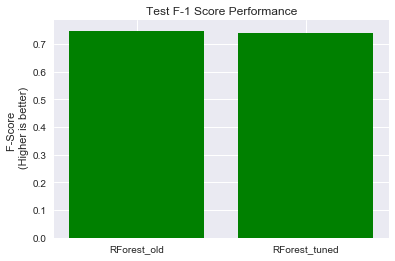

In [62]:
names, test_score = test_classifiers(X_test, y_test)
plotbar("_perfomance_test", names, test_score, "Test F-1 Score Performance", "F-Score \n (Higher is better)")

## 5. Save and Load Model

[Save and Load Model](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/)

In [63]:
rforest = joblib.load('model/RForest_tuned.sav')

## 6. Demo